C:\Users\Anh Vu\AppData\Local\Temp\ipykernel_13904\3066682021.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  src_img = imageio.imread('Pic2.jpg')
C:\Users\Anh Vu\AppData\Local\Temp\ipykernel_13904\3066682021.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tar_img = imageio.imread('Pic1.jpg')


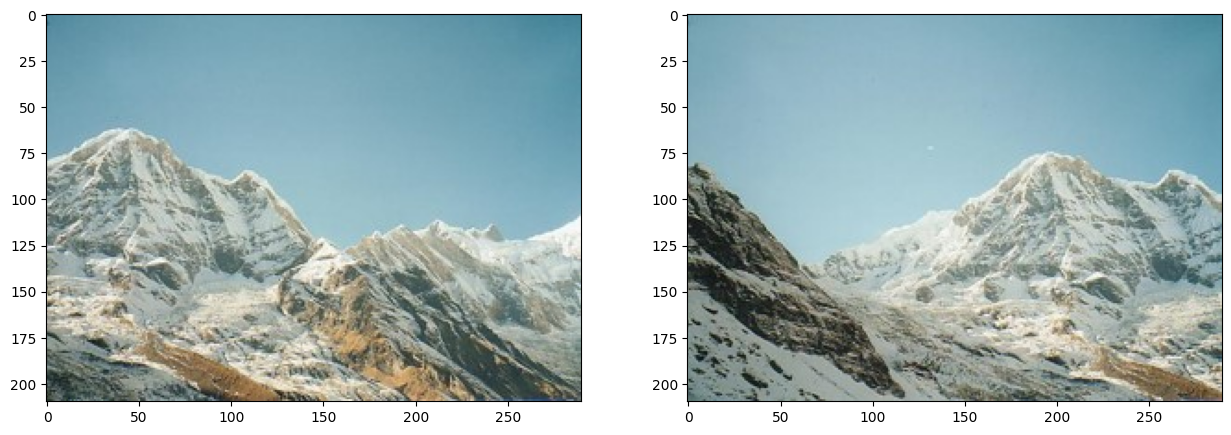

In [15]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio


def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


src_img = imageio.imread('Pic2.jpg')
tar_img = imageio.imread('Pic1.jpg')
src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)
plot_imgs([src_img, tar_img], size=8)


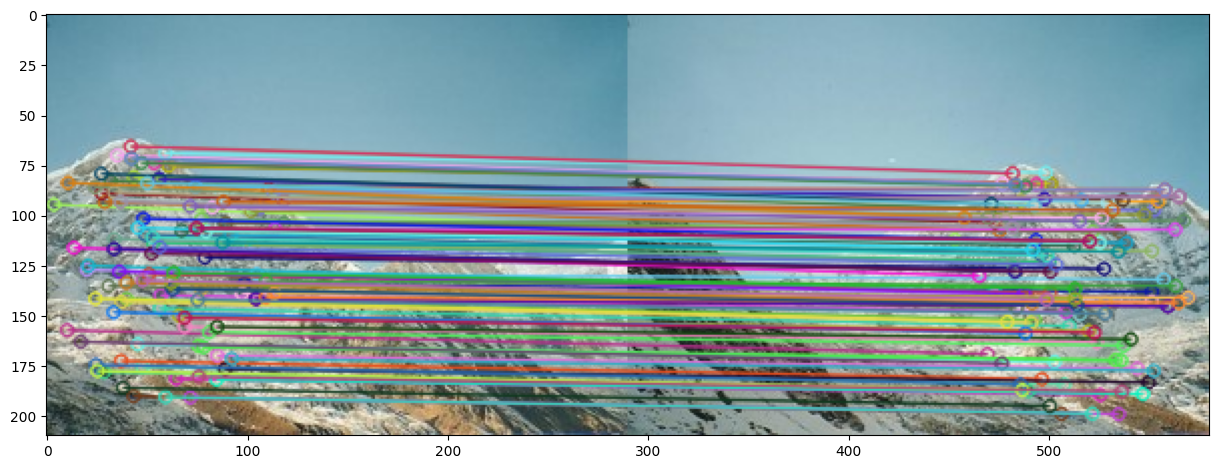

In [16]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(src_gray, None)
kp2, des2 = sift.detectAndCompute(tar_gray, None)

## Match keypoint
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list k ứng viên cho mỗi keypoint. 
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m,n in rawMatches:
    # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
    if m.distance < n.distance * 0.75:
        matches.append(m)

# do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_img(img3, size=(15, 10))

## Nhìn vào hình dưới đây, ta thấy các cặp Keypoint giữa 2 ảnh đã được match khá chính xác, số điểm nhiễu không quá nhiều


In [17]:
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])
pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])

# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)


[[ 5.80699460e-01  1.29700092e-01  1.45378220e+02]
 [-2.88062456e-01  8.59627694e-01  2.92504861e+01]
 [-1.34493677e-03 -1.87015890e-04  1.00000000e+00]]


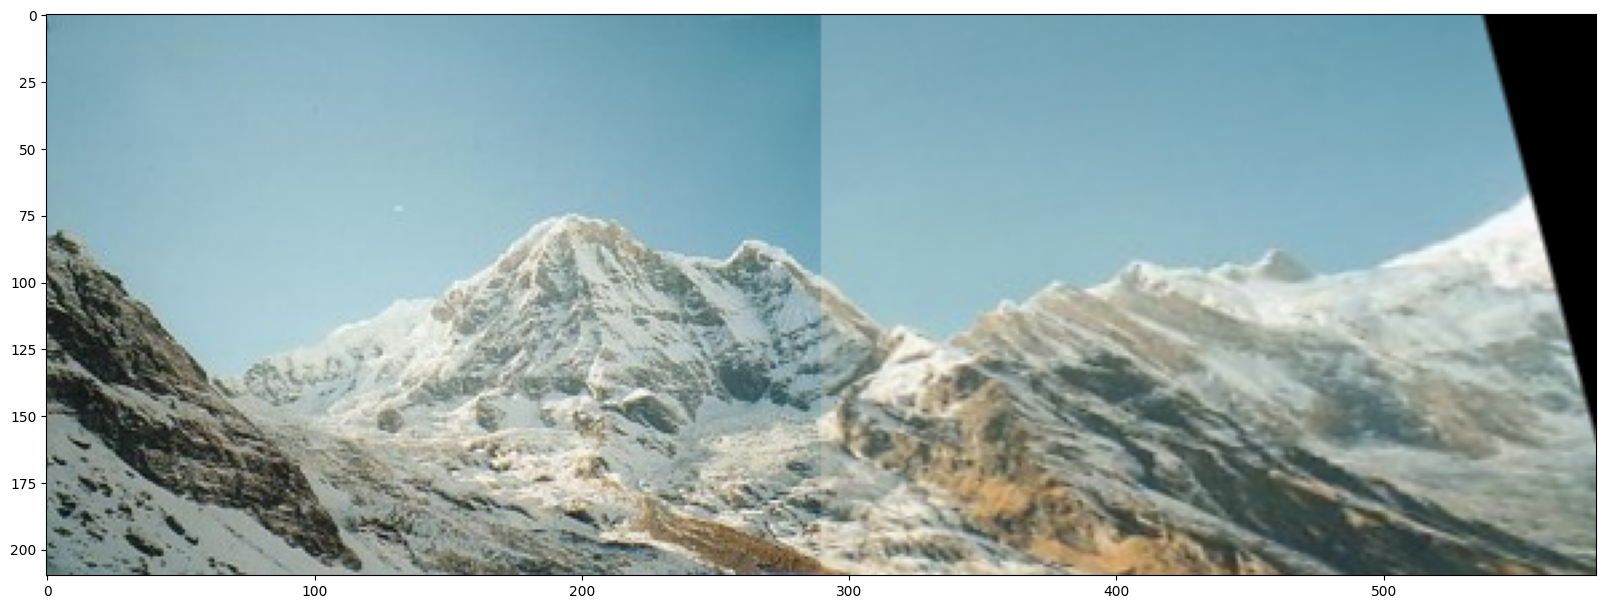

In [18]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]
result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img
plot_img(result, size=(20,10))
